<font size="10">Bistable Traveling Waves with PINNs</font>

<font size="4">This notebook employs a physics informed neural network (PINN) to demonstrate the existence of traveling wave solutions to the bistable reaction-diffusion equation: 
$\partial_t u = \partial_x^2 + u(1 - u)(u - a), \quad a \in (0,1), \quad u = u(x,t).$
</font>

<font size="4">Through a series of manipulations traveling wave solutions to the above partial differential equation are equivalent to solving the (parameterized) boundary value problem:
$U U' + cU + \xi(1 - \xi)(\xi - a), \quad U(0) = U(1) = 0, \quad \xi \in [0,1],$
</font>

<font size="4">where $U = U(\xi)$, $\xi = x - ct$ is the new independent variable and $c \in \mathbb{R}$ is the (unknown) speed of propagation.</font> 


<font size="4">The neural network is trained so that it approximates the function $\xi \mapsto U(\xi)$ for each $\xi \in [0,1]$. The wave speed parameter $c$ is considered as a trainable network parameter that is found through the training process.</font>

<font size="4">This code accompanies the work in Section 2.4.1. We use Tensorflow 2.0 to build the neural network, which is imported as tf. The general PINN framework here is adapted from the PINN in the repository [janblechschmidt/PDEsbyNNS](https://github.com/janblechschmidt/PDEsByNNs) from GitHub user [Jan Blechschmidt](https://github.com/janblechschmidt).</font>

In [257]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)

In [265]:
# Define residual of the ODE
def fun_r(c, x, u, u_x):
    a = 0.4
    return u*u_x + c*u + x*(1 - x)*(x - a)

In [244]:
# Set number of data points
N_r = 1000

# Set boundary
xmin = 0.
xmax = 1.
X_b = tf.concat([xmin, xmax], axis=0)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Interior points
X_r = tf.random.uniform((N_r,1), xmin, xmax, dtype=DTYPE)

In [245]:
def init_model(num_hidden_layers=12, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()
    
    # Create variable for the wave speed 
    model.c = tf.Variable(0.0, trainable = True)

    # Input is one-dimensional
    model.add(tf.keras.Input(1))

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('selu'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional 
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [246]:
def compute_loss(model, X_r, X_b):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        
        # Get evaluation points
        x = X_r
        
        # Variable x is watched during tape to compute derivative u_x
        tape.watch(x)

        # Determine residual 
        u = model(x)

        # Compute gradient u_x within the GradientTape
        u_x = tape.gradient(u, x)

    del tape
    
    # Get wave speed variable
    c = model.c
    
    # Define loss
    loss = tf.reduce_mean(tf.square(fun_r(c, x, u, u_x)))

    # Neumann boundary conditions in loss
    u0 = model(X_b)
    loss += tf.reduce_mean(tf.square(u0))
    
    return loss

In [247]:
def get_grad(model, X_r, X_b):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_b)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [248]:
# Initialize model aka u_\theta
model = init_model()

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-3,1e-4,1e-5])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [253]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_b)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

# Number of training epochs
N = 10000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.32446448e-05
It 00050: loss = 1.28985457e-05
It 00100: loss = 1.21844505e-05
It 00150: loss = 1.19463366e-05
It 00200: loss = 1.17917471e-05
It 00250: loss = 1.15987541e-05
It 00300: loss = 1.12519056e-05
It 00350: loss = 1.09923667e-05
It 00400: loss = 1.07704063e-05
It 00450: loss = 1.04398287e-05
It 00500: loss = 9.83711925e-06
It 00550: loss = 9.30382521e-06
It 00600: loss = 8.83561643e-06
It 00650: loss = 8.61326498e-06
It 00700: loss = 8.74531997e-06
It 00750: loss = 8.33367085e-06
It 00800: loss = 8.14454052e-06
It 00850: loss = 8.08160530e-06
It 00900: loss = 8.16378633e-06
It 00950: loss = 8.04065621e-06
It 01000: loss = 7.76642992e-06
It 01050: loss = 8.47353567e-06
It 01100: loss = 1.02654285e-05
It 01150: loss = 1.13624765e-05
It 01200: loss = 1.16149104e-05
It 01250: loss = 1.08014201e-05
It 01300: loss = 1.02235526e-05
It 01350: loss = 1.13638243e-05
It 01400: loss = 1.23310165e-05
It 01450: loss = 1.31081933e-05
It 01500: loss = 1.42426397e-05
It 01550

-0.14151582
tf.Tensor(
[[7.220311e-06]
 [5.493383e-05]], shape=(2, 1), dtype=float32)


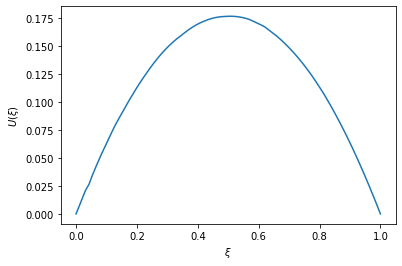

In [263]:
# View trained model specs
from matplotlib import pyplot as plt

# Predicted wave speed
print(model.c.numpy())

# Determine predictions of u(x)
X = tf.linspace(xmin,xmax, 5000)
upred = model(tf.cast(X,DTYPE))

# Plot results
plt.plot(X,upred)
plt.xlabel(r'$\xi$')
plt.ylabel(r'$U(\xi)$')

# Check boundary conditions
u_b = model(tf.cast(X_b,DTYPE))
print(u_b)

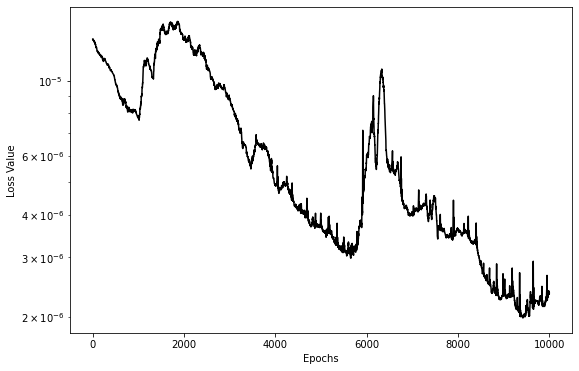

In [264]:
# View loss function values vs. number of epochs
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss Value');

In [256]:
# Save network config
#!mkdir -p traveling_wave_models
model.save('traveling_wave_models/twave_a=0.4')

INFO:tensorflow:Assets written to: traveling_wave_models/twave_a=0.4/assets


In [204]:
# Load saved model
# saved_model = tf.keras.models.load_model('traveling_wave_models/twave_a=0.1')
# saved_model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_337 (Dense)           (None, 20)                40        
                                                                 
 dense_338 (Dense)           (None, 20)                420       
                                                                 
 dense_339 (Dense)           (None, 20)                420       
                                                                 
 dense_340 (Dense)           (None, 20)                420       
                                                                 
 dense_341 (Dense)           (None, 20)                420       
                                                                 
 dense_342 (Dense)           (None, 20)                420       
                                                                 
 dense_343 (Dense)           (None, 20)              